<a href="https://colab.research.google.com/github/LukmaanViscomi/AI-Deep-Learning/blob/main/Baseline_Controlled_V5_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Unzip The Data

In [2]:
### Section 1: Setup and Dependencies
!apt-get install p7zip-full # Install 7-Zip
!pip install patool # Install the patool library which provides the patoolib module
import zipfile
import os
import patoolib # Now you can import patoolib

# Path to the uploaded zip file
zip_file_path = '/content/drive/MyDrive/dataset2 (1).zip'
extracted_folder_path = './dataset2'  # Use a relative path for the extraction directory

# Extract the zip file using patool
patoolib.extract_archive(zip_file_path, outdir=extracted_folder_path)

# List the contents of the extracted folder
extracted_files = os.listdir(extracted_folder_path)
print(extracted_files)

### Section 2 : Inspecting the Original Dataset


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.9/96.9 kB 6.2 MB/s eta 0:00:00


INFO patool: Extracting /content/drive/MyDrive/dataset2 (1).zip ...
INFO:patool:Extracting /content/drive/MyDrive/dataset2 (1).zip ...
INFO patool: ... creating output directory `./dataset2'.
INFO:patool:... creating output directory `./dataset2'.
INFO patool: running /usr/bin/7z x -o./dataset2 -- "/content/drive/MyDrive/dataset2 (1).zip"
INFO:patool:running /usr/bin/7z x -o./dataset2 -- "/content/drive/MyDrive/dataset2 (1).zip"
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: ... /content/drive/MyDrive/dataset2 (1).zip extracted to `./dataset2'.
INFO:patool:... /content/drive/MyDrive/dataset2 (1).zip extracted to `./dataset2'.


['triple_mnist']


### Redistribute The Dataset For Train/Val/Test

In [3]:
#
import os
import shutil
from pathlib import Path
import random

# Paths to original directories
original_base_dir = Path('dataset2/triple_mnist')
original_train_dir = original_base_dir / 'train'
original_val_dir = original_base_dir / 'val'
original_test_dir = original_base_dir / 'test'

# Path to the new dataset directory
new_base_dir = Path('dataset-c/triple_mnist')
new_train_dir = new_base_dir / 'train'
new_val_dir = new_base_dir / 'val'
new_test_dir = new_base_dir / 'test'

# Ensure the new directories exist
new_train_dir.mkdir(parents=True, exist_ok=True)
new_val_dir.mkdir(parents=True, exist_ok=True)
new_test_dir.mkdir(parents=True, exist_ok=True)

# Function to split and copy files
def split_and_copy_files(src_dir, new_train_dir, new_val_dir, new_test_dir, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2):
    if not src_dir.exists():
        return

    classes = sorted(os.listdir(src_dir))

    for cls in classes:
        cls_path = src_dir / cls
        if cls_path.is_dir():
            images = list(cls_path.glob('*'))
            random.shuffle(images)

            num_train = int(len(images) * train_ratio)
            num_val = int(len(images) * val_ratio)

            train_images = images[:num_train]
            val_images = images[num_train:num_train+num_val]
            test_images = images[num_train+num_val:]

            cls_train_dir = new_train_dir / cls
            cls_val_dir = new_val_dir / cls
            cls_test_dir = new_test_dir / cls

            cls_train_dir.mkdir(parents=True, exist_ok=True)
            cls_val_dir.mkdir(parents=True, exist_ok=True)
            cls_test_dir.mkdir(parents=True, exist_ok=True)

            for img in train_images:
                shutil.copy(str(img), str(cls_train_dir / img.name))
            for img in val_images:
                shutil.copy(str(img), str(cls_val_dir / img.name))
            for img in test_images:
                shutil.copy(str(img), str(cls_test_dir / img.name))

# Split and copy files from original train, val, and test directories
split_and_copy_files(original_train_dir, new_train_dir, new_val_dir, new_test_dir)
split_and_copy_files(original_val_dir, new_train_dir, new_val_dir, new_test_dir)
split_and_copy_files(original_test_dir, new_train_dir, new_val_dir, new_test_dir)

print("Files split and copied successfully!")

Files split and copied successfully!


### Imports and Initial Setup -Define Directory

In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight



### Data Generators for the Subset

In [5]:
# Define directories for training, validation, and testing datasets
train_dir = os.path.join('/content/dataset-c/triple_mnist/train')
val_dir = os.path.join('/content/dataset-c/triple_mnist/val')
test_dir = os.path.join('/content/dataset-c/triple_mnist/test')

# Image size and batch size
image_size = (42, 42)
batch_size = 32

# Create ImageDataGenerator with color_mode set to 'grayscale'
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load images with 'grayscale' mode
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',  # Convert images to grayscale
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',  # Convert images to grayscale
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',  # Convert images to grayscale
    shuffle=False
)

Found 60000 images belonging to 1000 classes.
Found 20000 images belonging to 1000 classes.
Found 20000 images belonging to 1000 classes.


### Build the model

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU


# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(train_generator.classes),
                                     y=train_generator.classes)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

# Initialize the model
cnn_model = Sequential()

# First convolutional layer with Leaky ReLU
cnn_model.add(Conv2D(32, (3, 3), input_shape=(42, 42, 1)))  # Note the change to 1 channel
cnn_model.add(LeakyReLU(alpha=0.01))
cnn_model.add(MaxPooling2D((2, 2)))

# Second convolutional layer with Leaky ReLU
cnn_model.add(Conv2D(64, (3, 3)))
cnn_model.add(LeakyReLU(alpha=0.01))
cnn_model.add(MaxPooling2D((2, 2)))

# Fully connected layer with Leaky ReLU
cnn_model.add(Flatten())
cnn_model.add(Dense(128))
cnn_model.add(LeakyReLU(alpha=0.01))
cnn_model.add(Dropout(0.5))

# Output layer with softmax activation for multi-class classification
cnn_model.add(Dense(train_generator.num_classes, activation='softmax'))

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Add a learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)


# Print the model summary
cnn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 40, 40, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 40, 40, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 20, 20, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 18, 18, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 9, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5184)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         663,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1000)                │         129,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 811,496 (3.10 MB)

 Trainable params: 811,496 (3.10 MB)

 Non-trainable params: 0 (0.00 B)

### Section 9: Early Stopping Callback

In [7]:
### Section 9: Callback for Early Stopping (Updated for longer patience)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,  # Increased patience for better fine-tuning
    restore_best_weights=True
)


### Train on Full Dataset (RUN 24-8-2024-8:29)

In [8]:

# # Train the model
# history = cnn_model.fit(
#     train_generator,
#     epochs=10,
#     validation_data=val_generator,  # Use the separate validation data
#     class_weight=class_weights,  # Use class weights if needed
#     callbacks=[lr_scheduler, early_stopping ]
# )

# # Plot learning curves
# plt.figure(figsize=(12, 4))

# plt.subplot(1, 2, 1)
# plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_accuracy'], label='val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.ylim([0, 1])
# plt.legend(loc='lower right')

# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss'], label='loss')
# plt.plot(history.history['val_loss'], label='val_loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend(loc='upper right')

# plt.show()

# # Evaluate the model
# test_loss, test_acc = cnn_model.evaluate(test_generator)
# print(f"Test accuracy: {test_acc}")


24:3:2024 - 18:30 - lets change one thing at a time: let try to go from 30 epocs down to 20 epocs

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 178s 93ms/step - accuracy: 0.0022 - loss: 6.8251 - val_accuracy: 0.0752 - val_loss: 4.6573 - learning_rate: 0.0010
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 167s 89ms/step - accuracy: 0.0686 - loss: 4.5098 - val_accuracy: 0.3183 - val_loss: 2.6005 - learning_rate: 0.0010
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 173s 92ms/step - accuracy: 0.2307 - loss: 2.9247 - val_accuracy: 0.6274 - val_loss: 1.4160 - learning_rate: 0.0010
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 203s 93ms/step - accuracy: 0.4586 - loss: 1.8561 - val_accuracy: 0.7650 - val_loss: 0.8959 - learning_rate: 0.0010
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 195s 89ms/step - accuracy: 0.6217 - loss: 1.2575 - val_accuracy: 0.8280 - val_loss: 0.6499 - learning_rate: 0.0010
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 205s 91ms/step - accuracy: 0.7093 - loss: 0.9573 - val_accuracy: 0.8525 - val_loss: 0.5398 - learning_rate: 0.0010
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 171s 91ms/step - accuracy: 

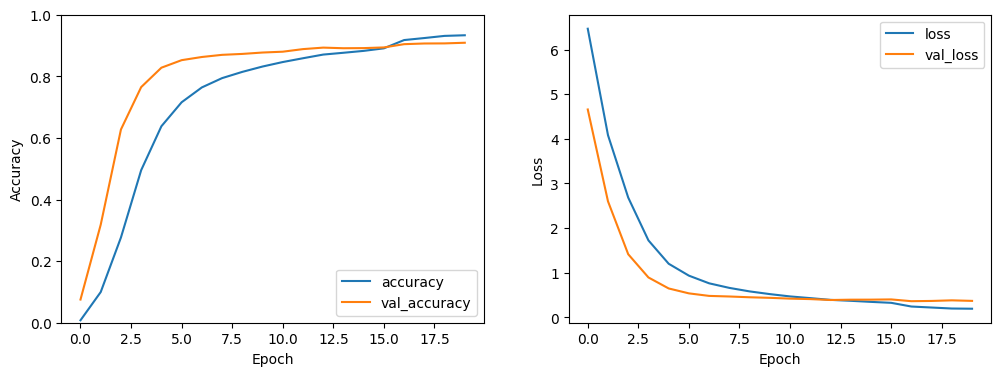

625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.9130 - loss: 0.3576
Test accuracy: 0.9030500054359436


In [9]:

# Train the model
history = cnn_model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,  # Use the separate validation data
    class_weight=class_weights,  # Use class weights if needed
    callbacks=[lr_scheduler, early_stopping ]
)

# Plot learning curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

# Evaluate the model
test_loss, test_acc = cnn_model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")


try to add batch mormaisaitons:

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 40, 40, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 40, 40, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 40, 40, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 18, 18, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 5184)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         663,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1000)                │         129,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 812,392 (3.10 MB)

 Trainable params: 811,944 (3.10 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 249s 131ms/step - accuracy: 0.0190 - loss: 6.4754 - val_accuracy: 0.4802 - val_loss: 2.4524 - learning_rate: 0.0010
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 237s 126ms/step - accuracy: 0.5097 - loss: 1.8985 - val_accuracy: 0.8160 - val_loss: 0.7232 - learning_rate: 0.0010
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 268s 129ms/step - accuracy: 0.7664 - loss: 0.8181 - val_accuracy: 0.8690 - val_loss: 0.4818 - learning_rate: 0.0010
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 240s 128ms/step - accuracy: 0.8218 - loss: 0.5943 - val_accuracy: 0.8795 - val_loss: 0.4160 - learning_rate: 0.0010
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 239s 127ms/step - accuracy: 0.8443 - loss: 0.5091 - val_accuracy: 0.8455 - val_loss: 0.5422 - learning_rate: 0.0010
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 263s 128ms/step - accuracy: 0.8665 - loss: 0.4277 - val_accuracy: 0.9081 - val_loss: 0.3186 - learning_rate: 0.0010
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 262s 128ms

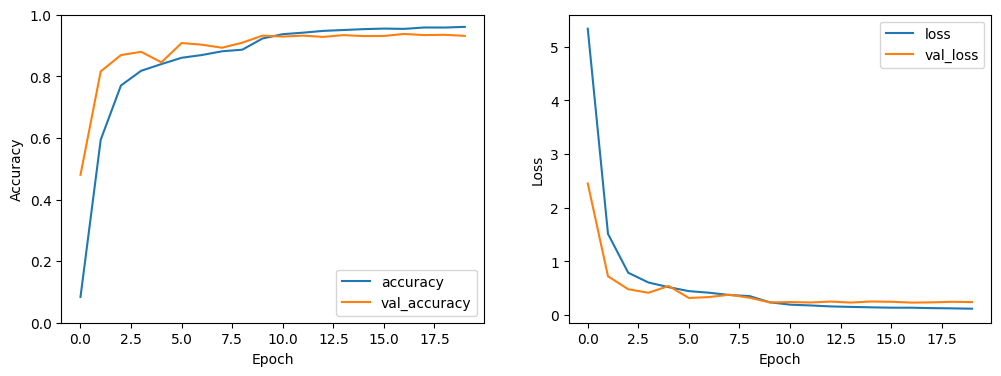

625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.9400 - loss: 0.2226
Test accuracy: 0.9336000084877014


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import tensorflow as tf

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

# Initialize the model
cnn_model = Sequential()

# First convolutional layer with Leaky ReLU and Batch Normalization
cnn_model.add(Conv2D(32, (3, 3), input_shape=(42, 42, 1)))  # Note the change to 1 channel
cnn_model.add(LeakyReLU(alpha=0.01))
cnn_model.add(BatchNormalization())  # Batch normalization after activation
cnn_model.add(MaxPooling2D((2, 2)))

# Second convolutional layer with Leaky ReLU and Batch Normalization
cnn_model.add(Conv2D(64, (3, 3)))
cnn_model.add(LeakyReLU(alpha=0.01))
cnn_model.add(BatchNormalization())  # Batch normalization after activation
cnn_model.add(MaxPooling2D((2, 2)))

# Fully connected layer with Leaky ReLU, Batch Normalization, and Dropout
cnn_model.add(Flatten())
cnn_model.add(Dense(128))
cnn_model.add(LeakyReLU(alpha=0.01))
cnn_model.add(BatchNormalization())  # Batch normalization after activation
cnn_model.add(Dropout(0.5))

# Output layer with softmax activation for multi-class classification
cnn_model.add(Dense(train_generator.num_classes, activation='softmax'))

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Add a learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Print the model summary
cnn_model.summary()

# Train the model
history = cnn_model.fit(
    train_generator,
    epochs=20,  # You can increase this if needed
    validation_data=val_generator,  # Use the separate validation data
    class_weight=class_weights,  # Use class weights if needed
    callbacks=[lr_scheduler, early_stopping]
)

# Plot learning curves
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

# Evaluate the model
test_loss, test_acc = cnn_model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")


In [3]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get true labels and predictions
true_labels = test_generator.classes
predictions = cnn_model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

test_accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Test Accuracy: {test_accuracy:.4f}")


# Generate classification report
class_labels = list(test_generator.class_indices.keys())  # List of class names
report = classification_report(true_labels, predicted_labels, target_names=class_labels)
print(report)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



NameError: name 'test_generator' is not defined

In [4]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'test_generator' has already been defined as per above example

# Get true labels and predictions
true_labels = test_generator.classes
predictions = cnn_model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate test accuracy
test_accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate classification report
class_labels = list(test_generator.class_indices.keys())  # List of class names
report = classification_report(true_labels, predicted_labels, target_names=class_labels)
print(report)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


NameError: name 'test_generator' is not defined

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


NameError: name 'true_labels' is not defined

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Compute Precision-Recall and plot curve
precision, recall, _ = precision_recall_curve(true_labels.ravel(), predictions.ravel())
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='CNN Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc

# Assuming you have binary or multilabel one-hot encoded labels
fpr, tpr, _ = roc_curve(true_labels.ravel(), predictions.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Plot learning curves
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()


In [ ]:
import numpy as np

# Get misclassified indices
misclassified_indices = np.where(true_labels != predicted_labels)[0]

# Plot some misclassified examples
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for i, ax in enumerate(axes):
    index = misclassified_indices[i]
    ax.imshow(test_generator[index][0].squeeze(), cmap='gray')
    ax.set_title(f"True: {class_labels[true_labels[index]]} Pred: {class_labels[predicted_labels[index]]}")
    ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.models import Model

# Choose a random image from the test set
img_index = 5
img = test_generator[img_index][0]
img = np.expand_dims(img, axis=0)

# Create a model that outputs the activations of the layers
layer_outputs = [layer.output for layer in cnn_model.layers[:6]]  # Visualize first 6 layers
activation_model = Model(inputs=cnn_model.input, outputs=layer_outputs)

# Get activations
activations = activation_model.predict(img)

# Plot the feature maps
fig, axes = plt.subplots(1, len(activations), figsize=(20, 8))
for i, ax in enumerate(axes):
    ax.matshow(activations[i][0, :, :, 0], cmap='viridis')
    ax.axis('off')
plt.show()
